<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Air France SEM Bookings - Model Development</h2><br>
<h4>BCH-7812 | Business Challenge II (February 25, 2024)</h4><br>
Team Flashd: <a href="https://www.linkedin.com/in/floris-splunter/" target="_blank">Floris van Splunter</a>, <a href="https://www.linkedin.com/in/lorena-cruz11/" target="_blank">Lorena Cruz</a>, <a href="https://www.linkedin.com/in/cla-wiese/" target="_blank">Constantin L. A. Wiese</a>, <a href="https://www.linkedin.com/in/saniyapaddalwar/" target="_blank">Saniya Paddalwar</a>, <a href="https://www.linkedin.com/in/hiroki-sakai-japan/" target="_blank">Hiroki Sakai</a>, & <a href="https://www.linkedin.com/in/davideromei/" target="_blank">Davide Romei</a><br><br>
Hult International Business School<br><br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Introduction</h2><br>
This project aimed to develop a predictive model for Air France's search engine marketing bookings, employing a comprehensive approach that integrated data preprocessing, exploratory analysis, and advanced statistical modeling. The initial phase focused on data quality assessment and visualization using R & Python, emphasizing identifying underlying patterns and ensuring data integrity. Exploratory data analysis was pivotal in revealing key insights, which informed the subsequent feature engineering and data transformation processes to enhance model performance.

The team explored several regression models, including Ordinary Least Squares, Lasso, and Ridge, to address the challenges of high dimensionality and overfitting. The Lasso Lars Regression Model emerged as the superior candidate, evidenced by its marginal outperformance over other models and its robustness in diagnostic evaluations, such as residual, QQ, and scale-location plots. This model demonstrated a remarkable ability to predict bookings with minimal noise, further refined by rounding predictions to whole numbers to reflect the discrete nature of bookings.

Ultimately, the Lasso Lars model's precision in capturing the essence of the data, coupled with its operational relevance for the discrete outcome of bookings, solidified its selection as the final model. The methodical approach from data inspection to model optimization reflects the analytical rigor necessary for effective predictive modeling in business.

<h2>Part I: Imports, Data Check, & Creating Visualization Functions</h2>

The Air France SEM Campaign data is loaded and checked. Visualization functions are defined.

In [1]:
# importing libraries
import warnings                          # suppressing warnings
import datetime                           # time data for submissions
import numpy as np                         # mathematical essentials
import pandas as pd                         # data science essentials
import matplotlib.pyplot as plt              # essential graphical output
import seaborn as sns                         # enhanced graphical output
from scipy import stats                        # box-cox transformation
from sklearn.tree import plot_tree              # tree plots
import statsmodels.formula.api as smf            # linear modeling
import sklearn.linear_model                       # faster linear models
from sklearn.linear_model import LassoLars         # LassoLars Regression
from sklearn.model_selection import train_test_split  # train/test split
from sklearn.model_selection import RandomizedSearchCV # hyperparameters

# suppressing warnings
warnings.filterwarnings("ignore")

# creating a results list
model_results = pd.DataFrame([], columns = ["Model Name", "train_RSQ",
                                            "test_RSQ", "tt_gap"])

In [2]:
# setting pandas print options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# reading modeling data into Python
modeling_data = "./datasets/df.csv"

# calling df
df = pd.read_csv(filepath_or_buffer = modeling_data,
                 header             = 0,
                 index_col          = "entry_id")

print(f"""
Original Dataset Size
------------------------
Observations: {df.shape[0]}
Features:     {df.shape[1]}
""") # formatting and printing the dimensions of the dataset

# identifying missing observation values in incomplete features
print(f"""
Missing Observations
-------------------------""")
print(len(df) - df.count()[df.count() != len(df)],"\n")


Original Dataset Size
------------------------
Observations: 4510
Features:     164


Missing Observations
-------------------------
bid_strategy    1224
bookings         100
dtype: int64 



In [3]:
def histplot(feature, df = df):
    """
    Function to create a histogram plot for a given feature.
    
    Parameters:
    - feature: The column name of the feature to plot.
    - df: The underlying dataset to use.
    """
    # Setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # Developing a histogram plot
    sns.histplot(data = df, x = feature, fill = True)
    
    # Drawing mean and median lines
    plt.axvline(x     = df[feature].mean(),
                color = "red",
                label = "Mean",
                alpha = 0.5)
    plt.axvline(x     = df[feature].median(),
                color = "blue",
                label = "Median",
                alpha = 0.5)
    
    # Adding legend to the plot
    plt.legend()
    
    # Displaying the plot
    plt.tight_layout()
    plt.show()

def boxplot(feature, feature_2, df = df):
    """
    Function to create a box plot for two features.
    
    Parameters:
    - feature: The column name of the feature for the x-axis.
    - feature_2: The column name of the feature for the y-axis.
    - df: The underlying dataset to use.
    """
    # Setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # Developing a box plot
    sns.boxplot(data = df, x = feature, y = feature_2)
    
    # Displaying the plot
    plt.tight_layout()
    plt.show()

def scatterplot(feature, feature_2, df = df):
    """
    Function to create a scatter plot for two features.
    
    Parameters:
    - feature: The column name of the feature for the x-axis.
    - feature_2: The column name of the feature for the y-axis.
    - df: The underlying dataset to use.
    """
    # Setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # Developing a scatter plot
    sns.scatterplot(data = df, x = feature, y = feature_2)
    
    # Displaying the plot
    plt.tight_layout()
    plt.show()

<h2>Part II: Exploratory Data Analysis, Data Preprocessing, & Feature Engineering</h2><br>
Several critical insights and actions were identified and executed in R that significantly eased the upcoming modeling process:

The analysis began by loading essential libraries in R, setting the working directory, and loading the training and testing datasets. Recognizing the importance of distinguishing between the training and testing sets, a "set" feature was created for each entry. Merging the datasets facilitated a unified approach to preprocessing and analysis.

Data inspection revealed the need for renaming columns to ensure clarity and consistency across variables. This step was crucial for clearly understanding each feature's role within the dataset.

Preprocessing involved converting various data formats into a more analyzable form. Currency values and percentages were transformed into numeric values, allowing for quantitative analysis. This transformation was essential for features such as bid amounts, costs, and rates, enabling numerical operations and analyses on these previously textual or formatted entries.

Exploratory data analysis highlighted missing values across several features, prompting the identification and documentation of these instances.

Feature engineering in R (Python feature engineering will follow) enhanced the dataset's analytical value. Publisher names were dissected to extract and categorize publishers and locations, transforming the keyword feature into a more nuanced set of variables that capture the presence of top keywords. Similarly, match types, campaigns, and keyword groups were analyzed and restructured to provide a granular view of their impact on search engine marketing outcomes.

The categorization of continuous variables into discrete groups based on their distribution (e.g., bid strategies, search engine bids, clicks, impressions) allowed for a more nuanced analysis of their effects.

Transforming and engineering features for numerical and categorical variables alike, log transformations, standardization, and normalization were applied to various metrics, enhancing model compatibility and interpretability. This meticulous preparation underscores the importance of feature scaling and transformation in predictive modeling.

The comprehensive approach to data preparation, exploratory analysis, and feature engineering significantly enhanced the dataset's utility for uncovering insights into Air France's search engine marketing strategy. By meticulously addressing data quality issues, transforming data formats, and ingeniously engineering features, the dataset was significantly prepared for in-depth analysis and modeling. The meticulous documentation and thoughtful analysis reflect a robust analytical methodology, setting the stage for in-depth analysis and modeling.

No missing values must be flagged or imputed, as R has already addressed this need.

<h3>Showcasing & Filtering Modeling Data</h3>

In [4]:
df.sort_values(by = "bookings",
               ascending = False).head(n = 3) # showcasing all features

,publisher_name,keyword,match_type,campaign,keyword_group,category,bid_strategy,status,se_bid,clicks,click_charges,cost_per_click,impressions,click_through_rate,avg_pos,conversion_rate,avg_conversion_cost,amount,costs,bookings,set,publisher_google,publisher_yahoo,publisher_overture,publisher_msn,publisher_loc_us,keyword_cheap,keyword_flight,keyword_paris,keyword_france,keyword_to,keyword_ticket,keyword_air,keyword_flights,keyword_airline,keyword_international,keyword_airfare,keyword_tickets,keyword_travel,keyword_europe,keyword_rome,keyword_fare,keyword_airport,keyword_italy,keyword_airlines,keyword_plane,keyword_air_france,keyword_other,match_type_advanced,match_type_broad,match_type_exact,match_type_standard,campaign_air_france,campaign_geo,campaign_other,campaign_unassigned,keyword_group_unassigned,keyword_group_sale,keyword_group_to,keyword_group_paris,keyword_group_france,keyword_group_international,keyword_group_york,keyword_group_europe,keyword_group_cheap,keyword_group_angeles,keyword_group_dc,keyword_group_boston,keyword_group_rome,keyword_group_air,keyword_group_francisco,keyword_group_houston,keyword_group_detroit,keyword_group_italy,keyword_group_nice,keyword_group_chicago,keyword_group_other,category_uncategorized,category_paris,category_ebsaleend,category_france,category_airfrance,category_other,bid_strategy_low_3_6,bid_strategy_low_5_10,bid_strategy_moderate_2_5,bid_strategy_target_1_2,bid_strategy_top_1_4,bid_strategy_unknown,status_deactivated,status_live,status_paused,status_sent,status_unavailable,se_bid_low,se_bid_moderate,se_bid_high,se_bid_extreme,se_bid_log,se_bid_standardized,se_bid_normalized,clicks_low,clicks_moderate,clicks_high,clicks_extreme,clicks_log,clicks_standardized,clicks_normalized,click_charges_low,click_charges_moderate,click_charges_high,click_charges_extreme,click_charges_log,click_charges_standardized,click_charges_normalized,cost_per_click_low,cost_per_click_moderate,cost_per_click_high,cost_per_click_extreme,cost_per_click_log,cost_per_click_standardized,cost_per_click_normalized,impressions_low,impressions_moderate,impressions_high,impressions_extreme,impressions_log,impressions_standardized,impressions_normalized,click_through_rate_low,click_through_rate_moderate,click_through_rate_high,click_through_rate_extreme,click_through_rate_log,click_through_rate_standardized,click_through_rate_normalized,avg_pos_low,avg_pos_moderate,avg_pos_high,avg_pos_extreme,avg_pos_log,avg_pos_standardized,avg_pos_normalized,conversion_rate_low,conversion_rate_moderate,conversion_rate_high,conversion_rate_extreme,conversion_rate_log,conversion_rate_standardized,conversion_rate_normalized,avg_conversion_cost_low,avg_conversion_cost_moderate,avg_conversion_cost_high,avg_conversion_cost_extreme,avg_conversion_cost_log,avg_conversion_cost_standardized,avg_conversion_cost_normalized,amount_low,amount_moderate,amount_high,amount_extreme,amount_log,amount_standardized,amount_normalized
entry_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mkt_814,Google - US,[air france],Exact,Air France Branded,Air France Brand,uncategorized,NaN,live,27.5,30418,13336.81,0.44,188409,0.1614,1.27,0.0144,30.38,515791.9,13336.81,439.0,train,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,3.349904,6.682846,1.000000,0,0,0,1,10.322823,28.515984,0.894331,0,0,0,1,9.498358,9.810468,0.288748,0,0,0,1,0.364643,-1.097165,0.044,0,0,1,0,12.146376,1.055745,0.022584,0,0,0,1,0.149626,0.247030,0.0807,0,1,0,0,0.819780,-0.613394,0.084667,0,0,0,1,0.014297,0.062812,0.001600,0,1,0,0,3.446171,0.012251,0.003166,0,0,0,1,13.153461,34.454177,0.908943
mkt_1536,Yahoo - US,airfrance,Advanced,Air France Branded,Air France Website,uncategorized,NaN,live,7.5,23893,17939.35,0.75,162070,0.1474,1.60,0.0176,42.61,567463.4,17939.35,421.0,train,0

In [5]:
df.drop( # dropping costs and all text features except set
    columns = ["publisher_name", "keyword", "match_type", "campaign",
               "keyword_group", "category", "bid_strategy", "status",
               "costs"], inplace = True)

All text features have been preprocessed in R and can be dropped. Only the set identifier is kept at this stage, but it will also be dropped later.

<h3>Dependent Variable Log Transformation</h3>

In [6]:
# applying log1p transformation
df["log_bookings"] = np.log1p(df["bookings"])

In [7]:
corr = df.select_dtypes(include = [ # analyzing (Pearson) correlations
    np.number]).corr(method = "pearson").round(2)
corr = corr.loc[ :,["bookings","log_bookings"] ].sort_values(by = "log_bookings", ascending = False)

# filtering for very high absolute correlations
corr_f = corr[(corr["bookings"] > 0.8) | (corr["bookings"] < -0.8) \
             | (corr["log_bookings"] > 0.8) | (corr["log_bookings"] < -0.8)]

# Calculate the higher absolute correlation for each feature and assign points
p_bookings     = 0
p_log_bookings = 0

for index, row in corr_f.iterrows():
    if abs(row["bookings"]) > abs(row["log_bookings"]):
        p_bookings += 1
    elif abs(row["bookings"]) < abs(row["log_bookings"]):
        p_log_bookings += 1
    # If they are equal, no points are awarded as per user instructions

percentage = 100 * (p_bookings / (p_bookings + p_log_bookings))
print(f"""Normal Bookings have {percentage:.2f}% of the times a higher \
correlation share in\ncorrelations above 0.8 than logarithmizised bookings.\
""")

corr_f # showing correlations

Normal Bookings have 80.00% of the times a higher correlation share in
correlations above 0.8 than logarithmizised bookings.


,bookings,log_bookings
log_bookings,0.61,1.00
amount_log,0.35,0.89
clicks_normalized,0.82,0.62
clicks_standardized,0.82,0.62
clicks,0.82,0.62
bookings,1.00,0.61
amount_standardized,0.99,0.60
amount,0.99,0.60
amount_normalized,0.99,0.60
amount_extreme,0.83,0.48


The correlation table shows that plain bookings are better suited for modeling than logarithmic bookings, given the significantly higher number of strong correlations in the former. The graphic below illustrates the strong right-skewness of the bookings. A large number of campaigns have no bookings at all. Many campaigns are run for testing purposes and are quickly discontinued. Others have no reach due to the lack of searches for associated keywords.

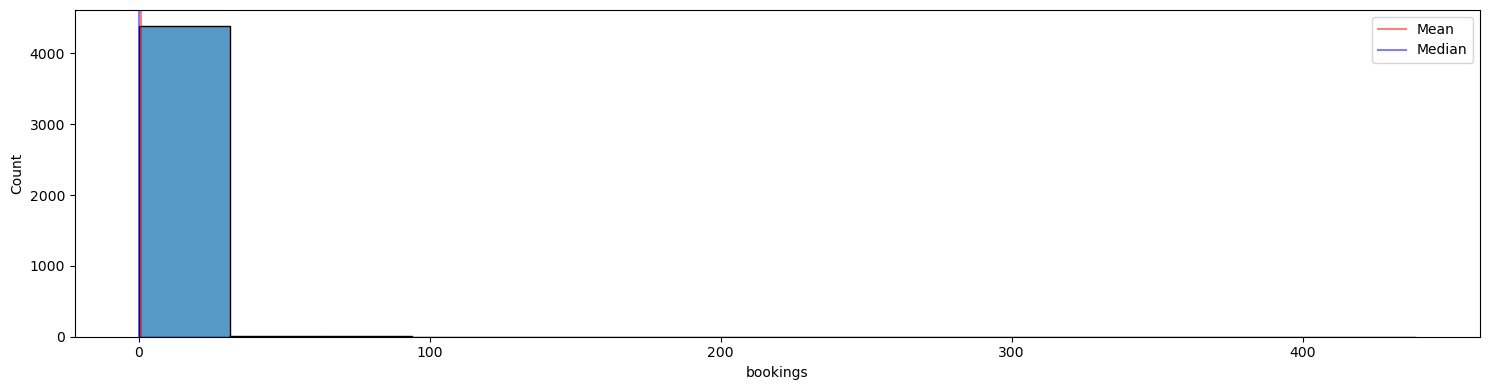

In the training set, 3992 campaigns have resulted in no bookings, whereas 418 campaigns resulted in 3395 bookings.


In [8]:
# visualizing dependent feature
histplot("bookings")     # user defined function

# Assuming df is your DataFrame and it contains 'bookings' and 'set' columns

# Counting the number of campaigns with no bookings
no_bookings_c = df["bookings"][df["bookings"] == 0].count()

# Adjusting the count by excluding records that belong to the "test" set
no_bookings_c -= df[df["set"] == "test"].count()["set"]

# Calculating total bookings 
bookings_c = df["bookings"].count() - no_bookings_c

# Sum of bookings in the training set
bookings = df[df["set"] == "train"]["bookings"].sum()

# Printing the results
print(f"""In the training set, {no_bookings_c} campaigns have resulted in no \
bookings, whereas {bookings_c} campaigns resulted in {int(bookings)} bookings.""")


<h3>Feature Engineering</h3>

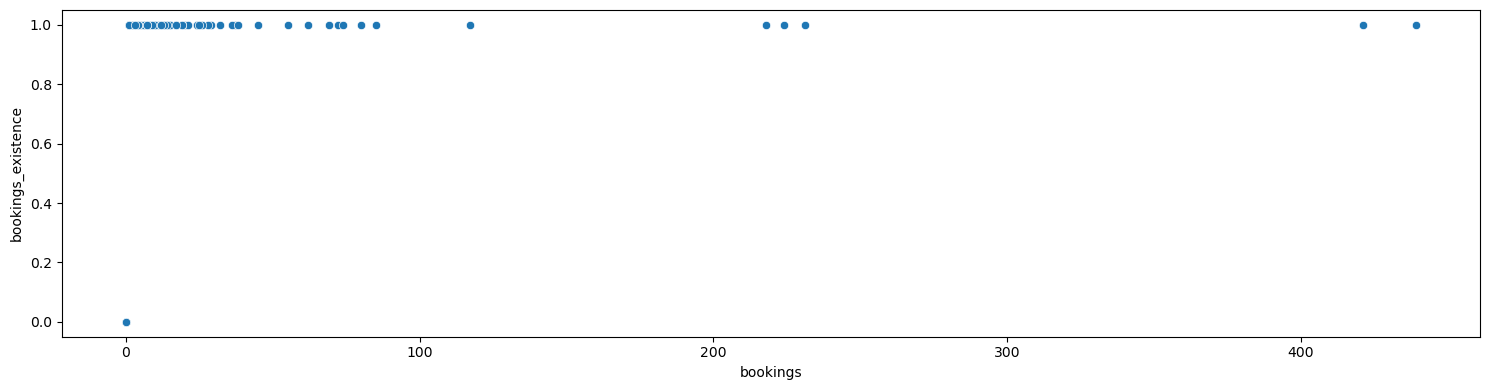

In [9]:
# engineering bookings_existence
df["bookings_existence"] = df["amount"].apply(
    lambda x: 1 if x > 0 else 0).astype(int)

scatterplot("bookings", "bookings_existence") # plotting observations

Firstly, it is determined whether bookings exist. As data on billing is available, the presence of a booking can be inferred. If the amount is greater than $0, it means money has flowed from the customer to the airline. Consequently, a flight was booked. If no payment has been made, then no booking occurred. This is also clearly visible in the scatter plot with bookings; when no booking exists, there are no bookings present.

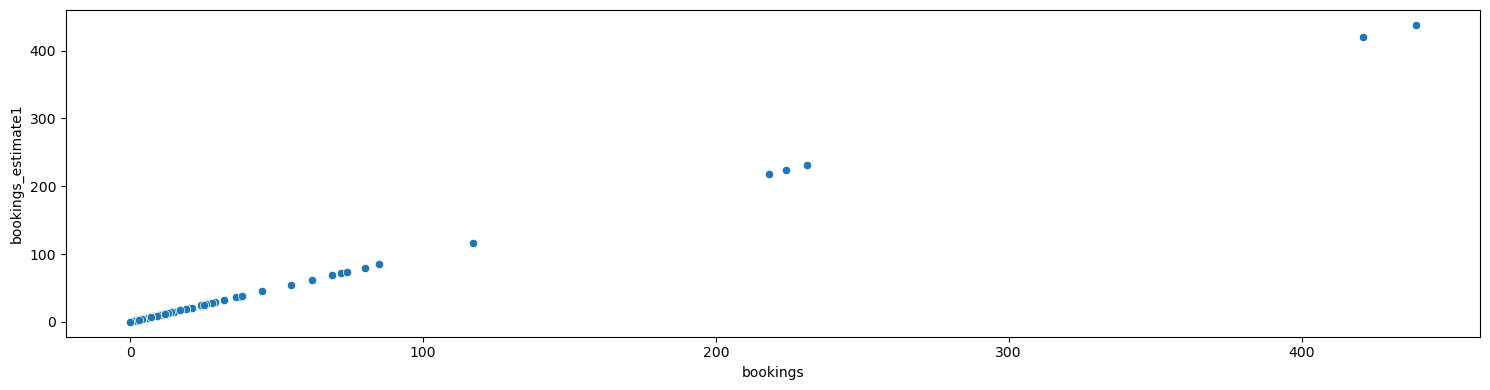

In [10]:
# engineering bookings_estimate1
df["bookings_estimate1"] = df["clicks"] * df["conversion_rate"]

scatterplot("bookings", "bookings_estimate1") # plotting observations

Bookings can be calculated by multiplying clicks by the conversion rate, with both values provided. This method facilitates the reconstruction of missing booking values. The scatter plot demonstrates that this holds in 100% of cases. It would be surprising if this were not the case. Hence, bookings_estimate1 acts as a perfect predictor for bookings.

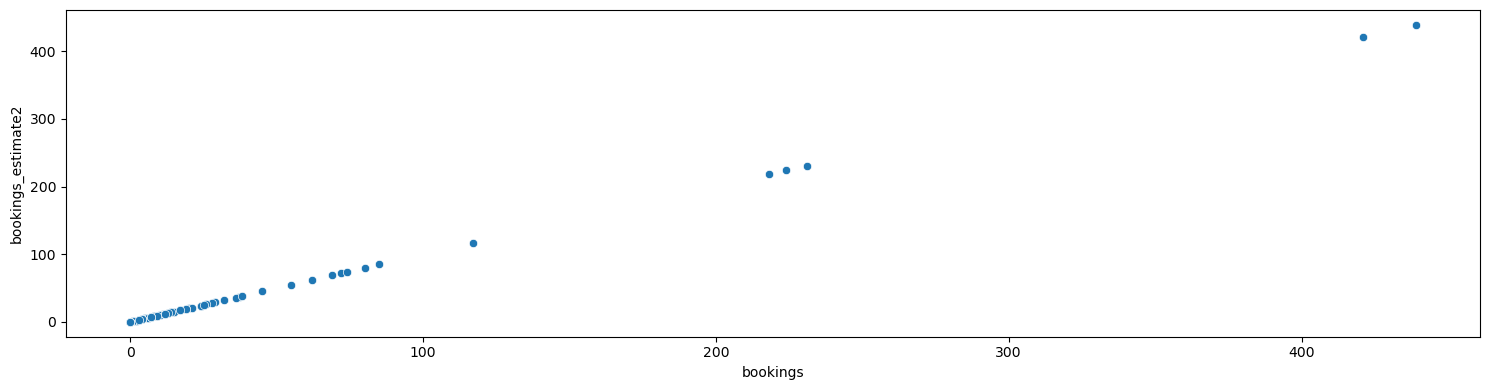

In [11]:
# feature bookings_estimate2
df["bookings_estimate2"] = np.where(df["avg_conversion_cost"] != 0,
                                    df["click_charges"] / df["avg_conversion_cost"],
                                    0)

scatterplot("bookings", "bookings_estimate2") # plotting observations

Similarly, click charges divided by the average conversion cost also result in bookings. By creating this second booking estimate feature, the accuracy of predicting the bookings can increase in robustness. As evident above, bookings_estimate2 predicts bookings to 100%. 

However, while promising for this Kaggle competition, this modeling approach may not be practically viable in real-world scenarios. Knowledge about the conversion rate and average booking costs for a company is unavailable before the launch of a campaign. Therefore, it is more practical to model which keywords and strategies will most likely result in bookings without considering financial data. This aspect was not the focus of this study and is therefore not addressed.

This distinction between theoretical modeling for competition purposes and practical application highlights the importance of recognizing the limitations and applicability of data science models. In real-world contexts, the emphasis should shift towards predicting outcomes based on controllable or influenceable variables before a campaign starts, like selecting the right keywords and strategies to optimize bookings.

<h3>Independent Variables Multiplication Transformation with bookings_existence</h3>

In [12]:
x = list(df.drop(labels = ["bookings",             # independent features
                           "log_bookings", "set"], axis = 1))

df_other = df[["bookings", "log_bookings", "set"]] # other features

# multiplying independent features with bookings_existence
df_x = df[x].multiply(df["bookings_existence"],axis = 0)

# reconcatinating dropped data after transformation
df = pd.concat([df_other, df_x], axis=1)

The feature bookings_existence is multiplied by each feature to make the predictions even more robust. This ensures that if no booking is recognizable, the characteristics do not distort the predictions in the direction of what would be expected in the event of a booking.

<h2>Part III: Data Partitioning</h2>
<h3>Separating the Kaggle Data</h3><br>
The dataset is divided into modeling and prediction data and the set identifier is dropped.

In [13]:
# parsing out testing data
kaggle_data = df[ df["set"] == "test" ].copy()             # dataset for kaggle
model_data  = df[ df["set"] == "train" ].copy()            # dataset for model building
kaggle_data.drop(labels = "set", axis = 1, inplace = True) # dropping kaggle identifier
model_data.drop(labels = "set", axis = 1, inplace = True)  # dropping model building identifier

In [14]:
# independent features
x_all         = [
    # original numerical data
    "se_bid",
    "clicks",
    "click_charges",
    "cost_per_click",
    "impressions",
    "click_through_rate",
    "avg_pos",
    "conversion_rate",
    "avg_conversion_cost",
    "amount",
              
    # publisher features
    "publisher_google", "publisher_yahoo", "publisher_overture",
    "publisher_msn", "publisher_loc_us",
              
    # keyword features
    "keyword_cheap", "keyword_flight", "keyword_paris", "keyword_france",
    "keyword_to", "keyword_ticket", "keyword_air", "keyword_flights",
    "keyword_airline", "keyword_international", "keyword_airfare",
    "keyword_tickets", "keyword_travel", "keyword_europe", "keyword_rome",
    "keyword_fare", "keyword_airport", "keyword_italy", "keyword_airlines",
    "keyword_plane", "keyword_air_france", "keyword_other",
              
    # match_type features
    "match_type_advanced", "match_type_broad", "match_type_exact",
    "match_type_standard",
              
    # campaign features
    "campaign_air_france", "campaign_geo",
    "campaign_other", "campaign_unassigned",
              
    # keyword_group features
    "keyword_group_unassigned", "keyword_group_sale", "keyword_group_to",
    "keyword_group_paris", "keyword_group_france",
    "keyword_group_international", "keyword_group_york",
    "keyword_group_europe", "keyword_group_cheap", "keyword_group_angeles", 
    "keyword_group_dc", "keyword_group_boston", "keyword_group_rome",
    "keyword_group_air", "keyword_group_francisco", "keyword_group_houston",
    "keyword_group_detroit", "keyword_group_italy", "keyword_group_nice",
    "keyword_group_chicago", "keyword_group_other",
              
    # category features
    "category_uncategorized", "category_paris", "category_ebsaleend",
    "category_france", "category_airfrance", "category_other",
              
    # bid_strategy features
    "bid_strategy_low_3_6", "bid_strategy_low_5_10",
    "bid_strategy_moderate_2_5", "bid_strategy_target_1_2",
    "bid_strategy_top_1_4", "bid_strategy_unknown",
              
    # status features
    "status_deactivated", "status_live", "status_paused",
    "status_sent", "status_unavailable",
    
    # se_bid features
    "se_bid_low", "se_bid_moderate", "se_bid_high", "se_bid_extreme",
    "se_bid_log", "se_bid_standardized", "se_bid_normalized",
    
    # clicks features
    "clicks_low", "clicks_moderate", "clicks_high", "clicks_extreme",
    "clicks_log", "clicks_standardized", "clicks_normalized",
    
    # click_charges features
    "click_charges_low", "click_charges_moderate", "click_charges_high",
    "click_charges_extreme", "click_charges_log",
    "click_charges_standardized", "click_charges_normalized",
    
    # cost_per_click features
    "cost_per_click_low", "cost_per_click_moderate", "cost_per_click_high",
    "cost_per_click_extreme", "cost_per_click_log",
    "cost_per_click_standardized", "cost_per_click_normalized",
    
    # impressions features
    "impressions_low", "impressions_moderate", "impressions_high",
    "impressions_extreme", "impressions_log",
    "impressions_standardized", "impressions_normalized",
    
    # click_through_rate features
    "click_through_rate_low", "click_through_rate_moderate",
    "click_through_rate_high", "click_through_rate_extreme",
    "click_through_rate_log", "click_through_rate_standardized",
    "click_through_rate_normalized",
    
    # avg_pos features
    "avg_pos_low", "avg_pos_moderate", "avg_pos_high", "avg_pos_extreme",
    "avg_pos_log", "avg_pos_standardized", "avg_pos_normalized",
    
    # conversion_rate features
    "conversion_rate_low", "conversion_rate_moderate",
    "conversion_rate_high", "conversion_rate_extreme",
    "conversion_rate_log", "conversion_rate_standardized",
    "conversion_rate_normalized",
    
    # avg_conversion_cost featues
    "avg_conversion_cost_low", "avg_conversion_cost_moderate",
    "avg_conversion_cost_high", "avg_conversion_cost_extreme",
    "avg_conversion_cost_log", "avg_conversion_cost_standardized",
    "avg_conversion_cost_normalized",
    
    # amount features
    "amount_low", "amount_moderate", "amount_high", "amount_extreme",
    "amount_log", "amount_standardized", "amount_normalized",
    
    # new features
    "bookings_existence", "bookings_estimate1", "bookings_estimate2"]

# specfifying features to drop in order to avoid multicollinearity
x_exclude     = ["keyword_air_france",     # equivalent to air and france
                 "publisher_overture",                   # publisher base
                 "keyword_france"                          # keyword base 
                 "match_type_standard",                 # match_type base
                 "campaign_unassigned",                   # campaign base
                 "keyword_group_unassigned",         # keyword_group base
                 "category_uncategorized",                # category base
                 "bid_strategy_unknown",              # bid_strategy base
                 "status_unavailable",                      # status base
                 "se_bid_extreme",                    # se_bid dummy base
                 "clicks_extreme",                    # clicks dummy base
                 "click_charges_extreme",      # click_charges dummy base
                 "cost_per_click_extreme",    # cost_per_click dummy base
                 "impressions_extreme",          # impressions dummy base
                 "click_through_rate_extreme",           # ctr dummy base
                 "avg_pos_extreme",                  # avg_pos dummy base
                 "conversion_rate_extreme",  # conversion_rate dummy base
                 "avg_conversion_cost_extreme", # avg. c. cost dummy base
                 "amount_extreme"]                    # amount dummy base

# x-features mc proof
x_mc_proof    = [x for x in x_all if x not in x_exclude]

# 
x_fit         = [
    # original features
    "se_bid", "clicks", "click_charges", "amount",
    
    # engineered R-features
    "publisher_google", "publisher_yahoo",
    "keyword_flights", "keyword_airline",
    "match_type_broad", "match_type_exact",
    "category_airfrance", "category_other",
    "bid_strategy_moderate_2_5",
    "status_paused", "status_sent",
    "se_bid_log", "se_bid_normalized",
    "clicks_log", "clicks_normalized",
    "click_charges_low", "click_charges_normalized",
    "cost_per_click_low", "cost_per_click_high", "cost_per_click_log",
    "impressions_low", "impressions_moderate", "impressions_high",
    "avg_pos_high",
    "conversion_rate_moderate", "conversion_rate_log",
    "conversion_rate_standardized",
    "avg_conversion_cost_low",
    "amount_log", "amount_normalized",
    
    # engineered Python-features
    "bookings_existence", "bookings_estimate1", "bookings_estimate2"]

# setting independent features
x_features   = x_fit

# setting dependent variable
y_variable    = "bookings"

In the script provided above, x_all encompasses all independent variables under consideration. The x_exclude list comprises variables to be omitted due to their categorical nature, which poses a risk of causing collinearity issues within models. The variables included in x_fit emerge from the model fitting process and are elaborated further in the script. Ultimately, the variables within x_fit are chosen for the modeling process, with bookings designated as the dependent variable.

In [15]:
# prepping data for train-test split
y_data = model_data[y_variable]
x_data = model_data[x_features]

<h3>Train-Test Split</h3>

In [16]:
# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.25,
                                                    random_state = 1836 )
# results of train-test split
print(f"""
Dimensions
----------
Target Feature:                {y_train.name}
Independent Features:          {x_data.shape[1]}

Original Dataset Observations: {df.shape[0]}
Training Data Observations:    {x_train.shape[0]}
Testing Data Observations:     {x_test.shape[0]}""")


Dimensions
----------
Target Feature:                bookings
Independent Features:          37

Original Dataset Observations: 4510
Training Data Observations:    3307
Testing Data Observations:     1103


<h3>Fit Model</h3><br>
Features denoted as x_mc_proof were initially incorporated into an ordinary least squares (OLS) regression model. Subsequently, an iterative process was employed to systematically eliminate any feature exhibiting a p-value exceeding the 5% threshold, with the objective of retaining only those whose p-values fell below this critical level. The culmination of this rigorous selection procedure is presented in the subsequent regression, showcasing the refined set of features. These optimally performing features have been meticulously documented and are accessible within the x_data code cell, located a few scrolls above in the document.

In [17]:
# instantiating a fit model
lm = smf.ols(formula = """bookings ~ se_bid + clicks + click_charges
+ amount + publisher_google + publisher_yahoo + keyword_flights
+ keyword_airline + match_type_broad + match_type_exact + category_airfrance
+ category_other + bid_strategy_moderate_2_5 + status_paused + status_sent
+ se_bid_log + se_bid_normalized + clicks_log + clicks_normalized
+ click_charges_low + click_charges_normalized + cost_per_click_low
+ cost_per_click_high + cost_per_click_log + impressions_low
+ impressions_moderate + impressions_high + avg_pos_high
+ conversion_rate_moderate + conversion_rate_log + conversion_rate_standardized
+ avg_conversion_cost_low + amount_log + amount_normalized
+ bookings_existence + bookings_estimate1 + bookings_estimate2""",
             data = model_data)

full_model = lm.fit()       # fitting the data
print(full_model.summary()) # printing results

                            OLS Regression Results                            
Dep. Variable:               bookings   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.008e+10
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:22:25   Log-Likelihood:                 26016.
No. Observations:                4410   AIC:                        -5.196e+04
Df Residuals:                    4376   BIC:                        -5.175e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

<h2>Part IV: Candidate Modeling</h2><br>
Before candidate models are developed, functions are created to facilitate this process.

In [18]:
# creating a modeling function
def model(model, name,
          coeff              = False,
          residuals          = False,
          qq_plot            = False,
          scale_location     = False,
          tree               = False,
          feature_importance = False):
    """
    Executes specified regression model on training data, evaluates its
    performance, and optionally generates various outputs.

    Parameters:
    - model: estimator object (regression model to use)
        This should be a scikit-learn-like model that
        has .fit(), .predict(), and .score() methods.
    - name: str
        Name of the regression model for identification in outputs.
    - coeff: bool, optional (default = False)
        If True, prints the model's coefficients.
        Not applicable for models without .coef_ attribute.
    - residuals: bool, optional (default = False)
        If True, plots residual errors between actual and predicted values.
    - tree: bool, optional (default = False)
        If True, plots the decision tree.
        Only applicable for decision tree models.
    - feature_importance: bool, optional (default = False)
        If True, plots the importance of features.
        Applicable for models with .feature_importances_ attribute.
    - qq_plot: bool, optional (default = False)
        If True, plots a QQ plot to compare the distribution of residuals 
        to a normal distribution.
    - scale_location: bool, optional (default = False)
        If True, plots a scale-location plot showing residuals spread.

    Outputs:
    - Print statements summarizing the model's performance, including
      training and testing scores, and the gap between these scores.
    - Optionally, outputs plots for residuals, decision tree visualization,
      and feature importance based on the parameters provided.
    - Stores the model's predictions on a provided Kaggle dataset to a CSV
      file for submission.

    Requires:
    - Variables x_train, y_train, x_test, y_test, x_data, model_results, and
      kaggle_data must be predefined in the global calling environment.
    - The pandas, numpy, matplotlib.pyplot, and seaborn libraries for
      data manipulation and plotting.

    Note:
    - This function assumes that the training and testing datasets
      (x_train, x_test, y_train, y_test), as well as feature names in x_data,
      are predefined and available in the calling environment.
    - The function updates the global model_results DataFrame with the
      current model's results and saves the predictions for the Kaggle
      competition to a file in the "./outputs" directory.
    - Designed to be flexible but expects a scikit-learn-compatible model.
    """
    global x_train, y_train, x_test, y_test, x_data
    global model_results, kaggle_data, y_variable
    
    ## Applying Model ########################################################        
    model_fit = model.fit(x_train, y_train)         # fitting training data
    model_pred = model.predict(x_test)              # predicting data

    # scoring results
    model_train_score = model.score(x_train, y_train).round(16) # using R-square
    model_test_score  = model.score(x_test, y_test).round(16)   # using R-square
    model_gap         = abs(model_train_score - model_test_score).round(16)
    
    # dynamically printing model summary
    print(f"""\
    Model Name:     {name}
    Train_Score:    {model_train_score}
    Test_Score:     {model_test_score}
    Train-Test Gap: {model_gap}""")
    
    ## Coefficients ##########################################################    
    if coeff == 1: # breaks if you try to use K-Neighbors/Tree with it
        # zipping each feature name to its coefficient
        model_coefficients = zip(x_data.columns,
                                 model.coef_.round(decimals = 4))
        
        # setting up a placeholder list to store model features
        coefficient_lst = [("intercept", model.intercept_.round(decimals = 4))]
        
        # printing out each feature-coefficient pair one by one
        for coefficient in model_coefficients:
            coefficient_lst.append(coefficient)
        
        print(f"""\nCoefficents
---------------------------------------
{pd.DataFrame(data = coefficient_lst, columns = ["Feature", "Coefficient"])}""")
    
    ## Residual Plot #########################################################    
    if residuals == True: # printing residuals when condition is met
        # applying model to validation set
        model_pred = model.predict(x_test).flatten()
        model_residuals = {"True"      : y_test,
                           "Predicted" : model_pred} # organizing residuals
        
        resid_df = pd.DataFrame(data = model_residuals) # converting residuals into df
        
        # setting figure size
        fig, ax = plt.subplots(figsize = (15, 6)) 
        
        # developing a residual plot
        sns.residplot(data        = resid_df,
                      x           = "Predicted",
                      y           = "True",
                      lowess      = True,
                      color       = "blue",
                      scatter_kws = {"alpha": 0.3},   # data transparency
                      line_kws    = {"color": "red"}) # line color
        
        # title and axis labels
        plt.title(label   = f"Residual Plot - {name} Model")
        plt.xlabel(xlabel = f"Predicted {y_variable.capitalize()}")
        plt.ylabel(ylabel = f"Actual {y_variable.capitalize()}")
        
        # layout and rendering visual
        plt.tight_layout()
        plt.show()
        
    ## QQ Plot ###############################################################
    if qq_plot == True:  # check if the QQ plot option is enabled
        residuals = y_test - model_pred         # calculate residuals
        fig, ax = plt.subplots(figsize = (15, 6))  # initialize figure
        stats.probplot(residuals,
                       dist = "norm",
                       plot = plt)  # comp. residuals to normal distribution
    
        # title, layout and rendering visual
        plt.title(f"QQ Plot - {name} Model")
        plt.tight_layout()
        plt.show()

    ## Scale-Location Plot ###################################################
    if scale_location:  # check if the scale-location plot option is enabled
        residuals = y_test - model_pred  # calculate residuals
        
        # Apply square root to absolute residuals to standardize
        standardized_residuals = np.sqrt(np.abs(residuals))
        
        # Initialize figure for plotting
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # Plot standardized residuals against predictions
        plt.scatter(x        = model_pred,
                    y        = standardized_residuals,
                    alpha    = 0.5)
        sns.regplot(x        = model_pred, 
                    y        = standardized_residuals,
                    scatter  = False,
                    ci       = False,
                    lowess   = True,
                    
                    # Add a lowess line to visualize trend
                    line_kws = {"color": "red", "lw": 1})
        
        # title, labels, layout and rendering visual
        plt.title(f"Scale-Location Plot - {name} Model")
        plt.xlabel(f"Predicted {y_variable.capitalize()}")
        plt.ylabel("Standardized Residuals")
        plt.tight_layout()
        plt.show()

    ## Decision Tree Plot ####################################################
    if tree == True: # printing tree
        # setting figure size
        plt.figure(figsize = (50, 6)) # adjusting to better fit the visual
        
        # developing a plotted tree
        plot_tree(decision_tree = model, # changing to pruned_tree_fit
          feature_names = list(x_data.columns),
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)
        
        # rendering the plot
        plt.tight_layout()
        plt.show()
        
    ## Feature Importance Plot ###############################################
    if feature_importance == True:
        # declaring the number
        n_features = x_data.shape[1]
        
        # setting plot window
        fig, ax = plt.subplots(figsize=(12,9))
        
        # plotting a feature importance visual
        plt.barh(range(n_features), model.feature_importances_, align = "center")
        plt.yticks(np.arange(n_features), x_data.columns)
        plt.xlabel("Feature importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        
    ## Model Results #########################################################
    # instantiating a list to store model results
    model_data = [ name, model_train_score, model_test_score, model_gap]

    # converting to DataFrame
    model_data = pd.DataFrame(data = model_data)

    # transposing (rotating) DataFrame
    model_data = np.transpose(model_data)

    # adding column names
    model_columns = ["Model Name", "train_RSQ", "test_RSQ", "tt_gap"]

    model_data.columns = model_columns

    # concatenating to model_results
   
    model_results = pd.concat(objs         = [model_results, model_data],
                    axis         = 0, ignore_index = True)

    ## Storing Predicitions ##################################################    
    # Prepare Kaggle data

    x_data_kaggle = kaggle_data[x_features].copy()  # x-data
        
    # Predicting on Kaggle data and rounding to full numbers
    kaggle_predictions = model.predict(x_data_kaggle).round(0).flatten()
        
    ## Kaggle Submission File ##
    # Organizing predictions
    model_predictions = {"Total Volume of Bookings": kaggle_predictions}
        
    # Converting predictions into df
    model_pred_df = pd.DataFrame(data = model_predictions,
                                 index = kaggle_data.index)
    
    # Identifying current time
    timestamp = datetime.datetime.now().strftime("%m-%d-%H-%M")
    
    # Format the model name: lowercase and replace spaces with underscores
    formatted_name = name.lower().replace(" ", "_")
    
    # Naming the model and saving predictions
    model_pred_df.to_csv(path_or_buf =  "./outputs/{}_{}.csv".format(
        timestamp, formatted_name), index = True, index_label = "entry_id")

    
def tune_and_display_results(model, name, parameters,
                             x_data = x_data, y_data = y_data, n = 3):
    """
    Performs hyperparameter tuning on a specified machine learning model
    using RandomizedSearchCV, which displays the top n tuning results
    in a structured format.

    Parameters:
    - model: The machine learning model to be tuned.
    - name: A string representing the name of the model.
    - parameters: A dictionary specifying the parameter grid for tuning.
    - x_data: The feature dataset used for training and testing.
    - y_data: The target variable.
    - n: An integer specifying the number of top n results to display.

    The function splits the dataset into training and testing sets, performs
    hyperparameter tuning to find the best parameters for the given model,
    and then processes the tuning results to display the top n configurations.
    The results include the rank, mean test score, standard deviation of the
    test score, and all the parameters tested in a pandas DataFrame.
    
    Returns:
    - A pandas DataFrame containing the top n tuning results
      with parameters in separate columns.
    """
    
    # Splitting the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = 0.25,
                                                        random_state = 1836)

    # Setting up and fitting the RandomizedSearchCV
    tuned_model_cv = RandomizedSearchCV(estimator           = model,
                                        param_distributions = parameters,
                                        cv                  = 5,
                                        n_iter              = 100,
                                        random_state        = 1836)
    tuned_model_cv.fit(x_data, y_data)

    # Displaying the best score achieved during tuning
    print(f"\nTop Tuned {name} Training AUC: {tuned_model_cv.best_score_.round(4)}")

    # Processing and displaying the tuning results
    cv_results = tuned_model_cv.cv_results_
    rows_list = []

    # Extracting the relevant data
    for rank, params, mean_score, std_score in zip(cv_results["rank_test_score"],
                                                   cv_results["params"],
                                                   cv_results["mean_test_score"],
                                                   cv_results["std_test_score"]):
        row = params.copy() # parameter settings as initial key-value pairs
        row.update({"Model_Rank": rank,
                    "Mean_Test_Score": mean_score,
                    "SD_Test_Score": std_score}) # loading in data
        rows_list.append(row)                    # storing data

    # Sorting and filtering the top n tuned results
    results_df = pd.DataFrame(rows_list).sort_values(by = "Model_Rank").head(n = n)

    # Adding parameter column names
    cols = ["Model_Rank", "Mean_Test_Score", "SD_Test_Score"] + \
           [col for col in results_df if col not in ["Model_Rank",
                                                     "Mean_Test_Score",
                                                     "SD_Test_Score"]]
    # Filtering and returning relevant output
    results_df = results_df[cols]
    return results_df

<h3>Ordinary Least Squares Regression</h3><br>
This model is equivalent to the fit model.

In [19]:
model(                               # Instantiating model
    model     = sklearn.linear_model.LinearRegression(), 
    name      = "Linear Regression") # Naming Model

    Model Name:     Linear Regression
    Train_Score:    0.9999999918788351
    Test_Score:     0.9999985403774218
    Train-Test Gap: 1.4515014134e-06


<h3>Lasso Regression</h3><br>
Since the fit model is already performing so well, here it is tested whether regularization with lasso has a positive effect.

In [20]:
param_grid_lasso = {                          # setting hyperparameter grid
    "tol": np.logspace(-6, -1, 20),           # stop criteria tolerance
    "selection": ["cyclic", "random"],        # coefficient update method
    "positive": [True, False],                # coefficients positive?
    "fit_intercept": [True, False],           # intercept calculation
    "alpha": np.arange(0, 0.1, 0.001)}        # regularization strength

# performing hyperparameter tuning
tune_and_display_results(model      =
                         sklearn.linear_model.Lasso( # instantiating model
                             random_state  = 1836,   # fixed random seed
                             copy_X        = True,   # copying X
                             warm_start    = False,  # starting fresh
                             precompute    = False,  # no precomputation
                             max_iter      = 500     # iteration count
                         ), name    = "Lasso Regression", # naming model
                         parameters = param_grid_lasso,   # using param grid
                         n          = 3)                  # n outputs


Top Tuned Lasso Regression Training AUC: 1.0


,Model_Rank,Mean_Test_Score,SD_Test_Score,tol,selection,positive,fit_intercept,alpha
51,1,0.999966,0.000028,0.000070,cyclic,False,False,0.014
32,2,0.999940,0.000049,0.000234,cyclic,False,False,0.012
90,3,0.999938,0.000051,0.000001,cyclic,True,False,0.041


In [21]:
model(                               # Instantiating model
    model     = sklearn.linear_model.Lasso(
        random_state  = 1836,        # fixed random seed
        copy_X        = True,        # copying X
        warm_start    = False,       # starting fresh   
        precompute    = False,       # no precomputation  
        max_iter      = 500,         # iteration count
        tol           = 0.000001,    # stop criteria tolerance
        selection     = "cyclic",    # coefficient update method
        positive      = False,       # coefficients positive?
        fit_intercept = False,       # intercept calculation 
        alpha         = 0.014),      # regularization strength
    name      = "Lasso Regression")  # Naming Model

    Model Name:     Lasso Regression
    Train_Score:    0.9999920919366458
    Test_Score:     0.999995076712549
    Train-Test Gap: 2.9847759031e-06


While this lasso model performs very well, the test score is slightly lower than in the fit model. Consequently, the lasso model is discarded.

<h3>Ridge Regression</h3><br>
Subsequently a ridge regression is created as a candidate model to try out a different error penalty idea.

In [22]:
param_grid_ridge = {                          # setting hyperparameter grid
    "tol":           [1e-4, 1e-3, 1e-2],      # solution precision
    "solver": ["auto", "svd", "cholesky",
               "lsqr", "sparse_cg", "sag",
               "saga", "lbfgs"],              # solver list
    "positive":      [True, False],           # coefficients positive?
    "fit_intercept": [True, False],           # intercept?
    "alpha":         np.arange(0.1,5,0.01)}   # regularization strength

# performing hyperparameter tuning
tune_and_display_results(model      =
                         sklearn.linear_model.Ridge( # instantiating model
                             random_state  = 1836,   # fixed random seed
                             copy_X        = True,   # copying X
                             max_iter      = 500     # iteration count
                         ), name    = "Ridge Regression", # naming model
                         parameters = param_grid_ridge,   # using param grid
                         n          = 3)                  # n outputs


Top Tuned Ridge Regression Training AUC: 1.0


,Model_Rank,Mean_Test_Score,SD_Test_Score,tol,solver,positive,fit_intercept,alpha
16,1,1.000000,2.154295e-07,0.0100,cholesky,False,True,0.11
37,2,0.999999,7.589707e-07,0.0010,cholesky,False,True,0.33
74,3,0.999999,9.162856e-07,0.0001,svd,False,False,0.41


In [23]:
model(                               # Instantiating model
    model     = sklearn.linear_model.Ridge(
        random_state  = 1836,        # fixed random seed
        copy_X        = True,        # copying X
        max_iter      = 500,         # iteration count
        tol           = 0.01,        # regularization strength
        solver        = "cholesky",  # solver selected
        positive      = False,       # coefficients positive?
        fit_intercept = True,        # intercept?
        alpha         = 0.11),       # regularization strength
    name      = "Ridge Regression")  # Naming Model

    Model Name:     Ridge Regression
    Train_Score:    0.99999991648598
    Test_Score:     0.9999999091689742
    Train-Test Gap: 7.3170058e-09


The change to ridge regression is excellent. The test score has seven 9s after the decimal point and is therefore almost equal to 1.

<h3>Final Model: Lasso Lars Regression</h3><br>
The last model to be tested is lasso lars, a combination that is particularly good for outlier data, as can be seen immediately.

In [24]:
param_grid_lassolars = {             # setting hyperparameter grid
    "verbose": [True, False],        # detailed logging of fitting process?
    "precompute": [True, False],     # precompute Gram matrix?
    "positive": [True, False],       # restrict coefficients to be positive?
    "normalize": [True, False],      # Normalization?
    "fit_path": [True, False],       # store full path?
    "fit_intercept": [True, False],  # intercept calculation?
    "eps": np.logspace(-16, -8, 10), # Machine-precision regularization
    "alpha": np.logspace(-4, 1, 20), # regularization strength
}


# performing hyperparameter tuning
tune_and_display_results(model      =
                         LassoLars( # instantiating model
                             random_state  = 1836,   # fixed random seed
                             copy_X        = True,   # copying X
                             max_iter      = 500,    # iteration count
                             jitter        = None    # no upper noise bound
                         ), name    = "Lasso Lars Regression", # naming model
                         parameters = param_grid_lassolars,    # using grid
                         n          = 3)                       # n outputs


Top Tuned Lasso Lars Regression Training AUC: 1.0


,Model_Rank,Mean_Test_Score,SD_Test_Score,verbose,precompute,positive,normalize,fit_path,fit_intercept,eps,alpha
79,1,1.0,3.085536e-08,False,False,True,False,True,True,5.994843e-15,0.000183
9,2,1.0,2.979645e-08,True,False,False,True,True,False,1.000000e-08,0.000183
28,3,1.0,2.976457e-08,True,True,False,False,True,True,2.154435e-11,0.000183


    Model Name:     Lasso Lars Regression
    Train_Score:    0.9999999744810149
    Test_Score:     0.9999999899118234
    Train-Test Gap: 1.54308085e-08

Coefficents
---------------------------------------
                         Feature  Coefficient
0                      intercept      -0.0001
1                         se_bid       0.0000
2                         clicks       0.0000
3                  click_charges       0.0000
4                         amount       0.0000
5               publisher_google       0.0000
6                publisher_yahoo       0.0000
7                keyword_flights       0.0000
8                keyword_airline       0.0000
9               match_type_broad       0.0000
10              match_type_exact       0.0000
11            category_airfrance       0.0000
12                category_other       0.0000
13     bid_strategy_moderate_2_5       0.0000
14                 status_paused       0.0000
15                   status_sent       0.0000
16        

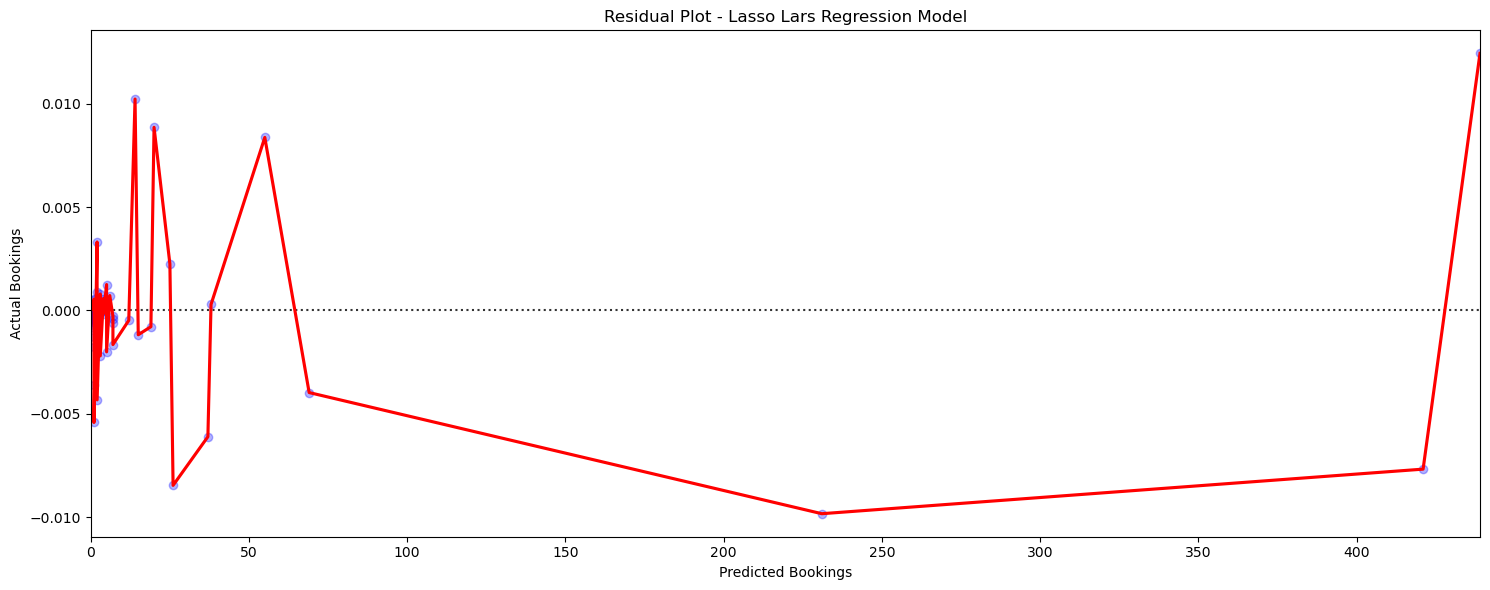

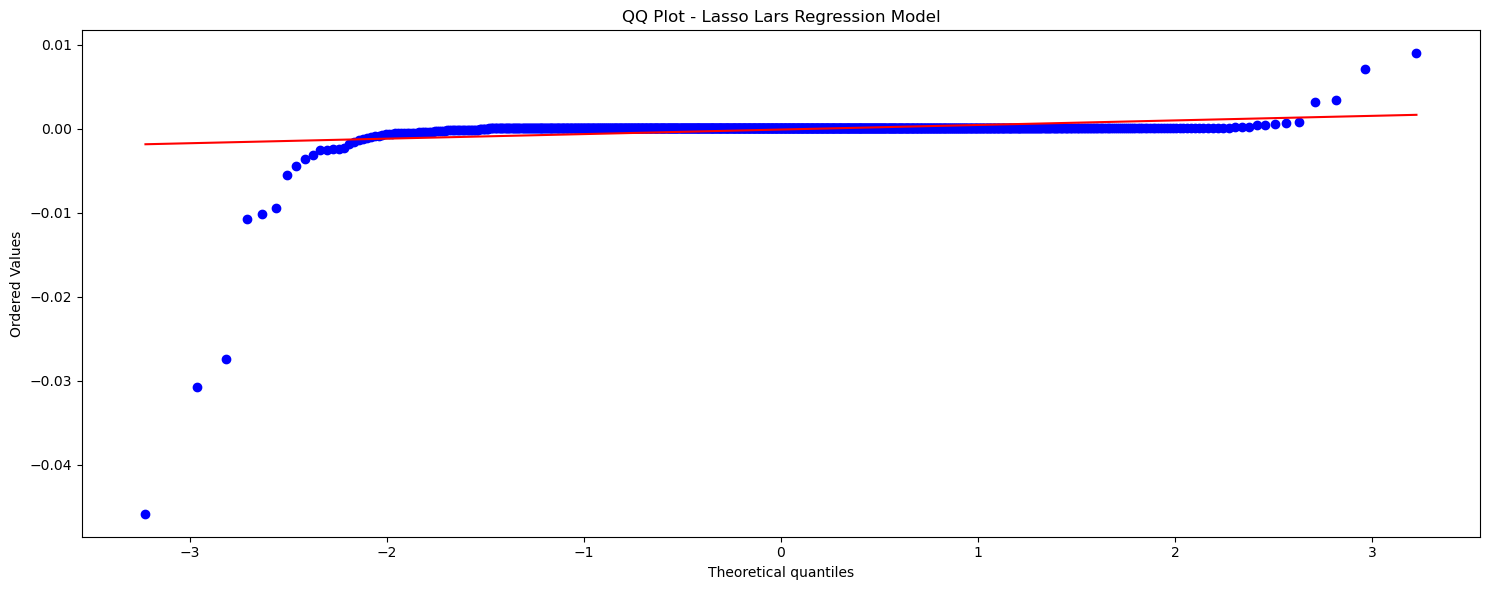

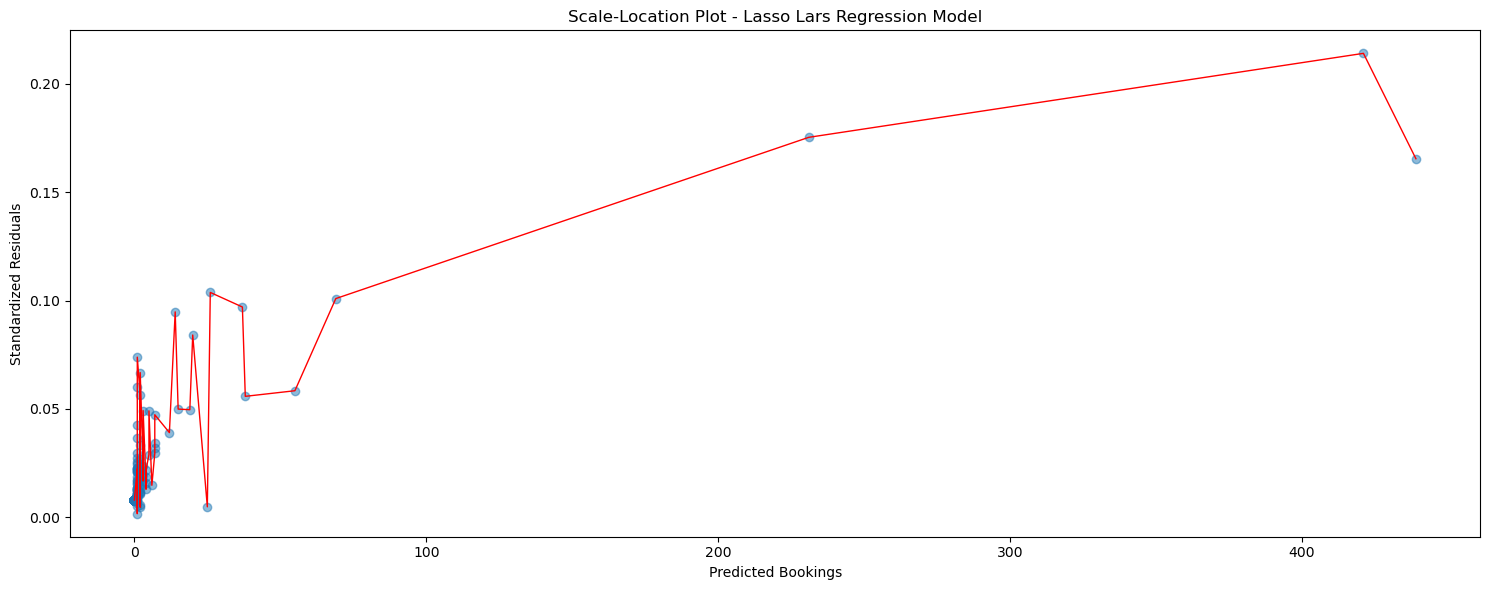

In [25]:
model(                                    # Instantiating model
    model     = LassoLars(
        random_state  = 1836,             # fixed random seed
        copy_X        = True,             # copying X
        max_iter      = 500,              # iteration count
        jitter        = None,             # no upper noise bound     
        verbose       = False,            # no detailed logging of fitting process
        precompute    = False,            # no precomputed Gram matrix
        positive      = True,             # only posiitve coefficients
        normalize     = False,            # no normalization (already done)
        fit_path      = True,             # store full path
        fit_intercept = True,             # calculate intercept
        eps           = 5.994843e-15,     # Machine-precision regularization
        alpha         = 0.000183),        # regularization strength
    name           = "Lasso Lars Regression",  # Naming Model
    coeff          = True,                     # Coefficients
    residuals      = True,                     # Residuals
    qq_plot        = True,                     # QQ Plot
    scale_location = True,)                    # Scale Location Plot

When examining the performance metrics with scrupulous attention to detail, the Lasso Lars Regression Model demonstrates a slight edge over the Ridge Regression counterpart. The Lasso Lars model achieves a marginally superior test value, with the eighth decimal place being 8, compared to the Ridge model's corresponding figure resting at 0. Though seemingly negligible, this granular level of improvement is pivotal in selecting the Lasso Lars as the superior model for the final application.

Upon closer inspection of the diagnostic plots, the residual plot for the Lasso Lars model reveals that as the predicted number of bookings increases, the noise terms in the predictions exhibit a slight upward trend. However, the residuals remain consistently below the 0.5 mark, which suggests that the model's predictions are robust, albeit with a minor presence of noise. This is an important observation, as it suggests that the model's predictions are close to the actual values and maintain a low variability, a desirable quality for predictive accuracy.

The QQ plot further reinforces the model's efficacy, displaying that the residuals are broadly concord with a normal distribution, particularly in the central quantiles. Nevertheless, heavier tails than expected for a normal distribution indicate that the model may not fully capture the extreme values effectively. This was addressed by examining the model's parameters to reflect the data's behavior more accurately.

The scale-location plot uncovers an additional layer of complexity. It indicates a potential violation of the homoscedasticity assumption, as evidenced by the increasing spread of residuals with larger predicted bookings. This heteroscedasticity suggests that the model's performance is inconsistent across all levels of predicted bookings, with variability in the residuals becoming more pronounced as the number of bookings grows.

A pragmatic approach is adopted to refine the model's output further by rounding the predicted values to the nearest whole number. Given that bookings are discrete and cannot occur in fractions, this rounding-off enhances the practical applicability of the model's outputs, ensuring that the predictions are statistically sound and operationally relevant.

Even without this rounding technique, the near-perfect alignment of the residuals around the zero line for a substantial range of predicted values underscores the Lasso Lars model's high precision. The minimal deviations suggest that the model captures the underlying pattern in the data with high accuracy, which is commendable considering the complexity inherent in modeling real-world phenomena such as bookings.

In summary, through its nuanced penalty optimization, the Lasso Lars Regression Model balances the trade-off between bias and variance, achieving a commendable level of prediction accuracy. Its marginal outperformance over the Ridge model and consistency across various diagnostic measures solidify its position as the choice model for predicting bookings. The residual, QQ, and scale-location plots collectively provide a comprehensive view that guides the final model refinement, ensuring statistically robust, practically grounded predictions directly applicable to the operational context.

<h2>Part V: Model Results</h2><br>
Here, an overview of all model results is provided. The Lasso Lars Regression is selected as the final model.

In [26]:
model_results # showing all model results

,Model Name,train_RSQ,test_RSQ,tt_gap
0,Linear Regression,1.0,0.999999,0.000001
1,Lasso Regression,0.999992,0.999995,0.000003
2,Ridge Regression,1.0,1.0,0.0
3,Lasso Lars Regression,1.0,1.0,0.0


~~~                                    _                                     
   / \   _ __ ___   _   _  ___  _   _     
  / _ \ | '__/ _ \ | | | |/ _ \| | | |    
 / ___ \| | |  __/ | |_| | (_) | |_| |    
/_/   \_\_|  \___|  \__, |\___/ \__,_|    
                      ___/                                        
 _____ _       _    ___   _   _ ____ ___ 
|  ___| |     / \  / ___|| | | |  _ \__ \
| |_  | |    / _ \ \___ \| |_| | | | |/ /
|  _| | |__ / ___ \ ___) |  _  | |_| |_| 
|_|   |____/_/   \_\____/|_| |_|____/(_) 
~~~

<br>